In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
from sympy import symbols, exp as sexp, diff, Derivative, Eq

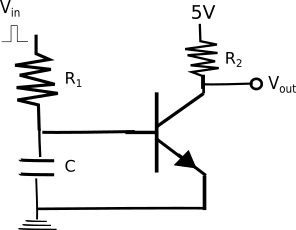

The object was to measure the voltage at the base of the transmitter (and later on at the base of R2) to determine the characteristics of the transistor.  Specifically to estimate the thermal coefficient $V_T$ and the scale current $I_{ES}$. The capacitor was to produce a comparatively slowly changing transistor base voltage with hopefully enough time for me to make measurements using an Arduino.  (This has since become slightly more complicated because the Arduino analog inputs have a time lag of 100 $\mu S$ which may add some measurement bias).

In [3]:
r1, r2, c, issym, vt, vin, vout, vbe, vc, t = symbols("R1 R2 C I_{ES} V_T V_{in} V_{out} V_{BE} V_C t")

In [4]:
 Eq((vin - vc)/r1 - c * Derivative(vc,t) - issym*(sexp(vc/vt)-1),0)

Eq(-C*Derivative(V_C, t) - I_{ES}*(exp(V_C/V_T) - 1) + (-V_C + V_{in})/R1, 0)

The above is a differential equation for the R1, C and base-emitter junction.  $V_C$ is the voltage across the capacitor.  Vin is a choice of 0 or 5 Volts as it is connected to one of the outputs of the Arduino digital pins.  By turning it on or off I was hoping to sweep through a range of voltages controlled by the time constand of R1 $\times$ C.  In my case R1 = 6K8 and C = $100 \mu F$.  I think R2 is about 470 $\Omega$.

It's basically a non linear differential equation which is impossible to solve using analytical methods.  Hence the attempt to solve it below using numerical methods.

Now I try to build my theoretical model using the equation above and some scientific libraries to integrate the equation to find what the solution would look like over time.
I am basically plotting the voltage across the capacitor as function of time.

In [5]:
def model(t, y, vin):
    vcc=vin
    vt =  0.0321850033399526
    isval = 1.602564611659814e-12
    r=6800
    c=100e-6
    
    vc = y
    try:
        vcp =  (vcc-vc)/(r*c) - isval * (exp(vc/vt)-1) /(c)
    except OverflowError:
        print (vc)
        return np.inf
    #print (vcp)
    return vcp
    
    

In [6]:
teval = np.linspace(0, .4,100)
res = solve_ivp(model, (0,.4), (0,),args=(5,), t_eval = teval, first_step=0.001)

[56.81583729]


/opt/conda/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


In [7]:
x = res.t
y = res.y[0]

Text(0.5, 1.0, 'Charging of $V_C$ over time(t)')

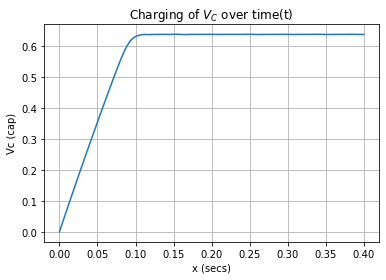

In [8]:
fig, ax = plt.subplots()

ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.set_title("Charging of $V_C$ over time(t)")

In [9]:
teval = np.linspace(0, 1,100)
res = solve_ivp(model, (0,1), (.7,),args=(0,), t_eval = teval, first_step=0.001)

In [10]:
x = res.t
y = res.y[0]

Text(0.5, 1.0, 'Discharging of C over time(t)')

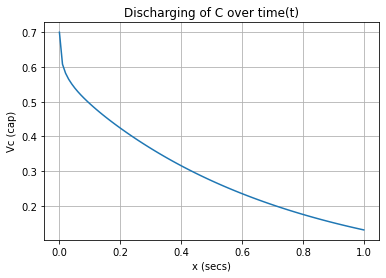

In [11]:
fig, ax = plt.subplots()

ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.set_title("Discharging of C over time(t)")

The results are unsurprising as the capacitor charges up to ( or discharges from ) 0.7 volts approximately.  Anything higher and the transistor conducts so the results are at least realistic.

Now I look at the results obtained from direct measurement via the Arduino analog input pin.

In [12]:
measurements = np.array([[ 0, 11, 0.05], 
[ 4, 17, 0.08], 
[ 8, 23, 0.11], 
[ 12, 29, 0.14], 
[ 16, 34, 0.17], 
[ 20, 40, 0.20], 
[ 24, 45, 0.22], 
[ 28, 50, 0.24], 
[ 32, 57, 0.28], 
[ 36, 62, 0.30], 
[ 40, 68, 0.33], 
[ 44, 73, 0.36], 
[ 48, 78, 0.38], 
[ 52, 84, 0.41], 
[ 56, 90, 0.44], 
[ 60, 95, 0.46], 
[ 65, 100, 0.49], 
[ 69, 105, 0.51], 
[ 73, 110, 0.54], 
[ 77, 116, 0.57], 
[ 81, 121, 0.59], 
[ 85, 127, 0.62], 
[ 89, 135, 0.66], 
[ 93, 144, 0.70], 
[ 97, 159, 0.78], 
[ 101, 183, 0.89], 
[ 105, 193, 0.94], 
[ 109, 195, 0.95], 
[ 113, 196, 0.96], 
[ 117, 198, 0.97], 
[ 121, 198, 0.97], 
[ 125, 197, 0.96], 
[ 129, 198, 0.97], 
[ 133, 198, 0.97], 
[ 137, 198, 0.97], 
[ 141, 198, 0.97], 
])

In [13]:
dfmeasure =  pd.DataFrame(measurements)
dfmeasure.columns = ['time', 'ADC', 'volts']
# ADC is the measure obtained from Arduino analogRead which returns a value from 0 to 1023.
# I divide that by 1024 and multiply by 5 to get a voltage.

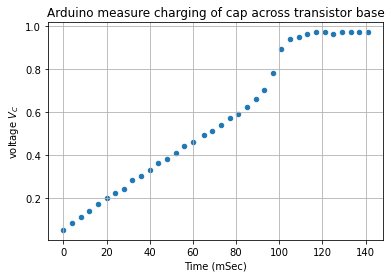

In [14]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure charging of cap across transistor base')


ax1 = dfmeasure.plot('time', 'volts', kind='scatter', ax=ax)
ax1.set_xlabel('Time (mSec)')
ax1.set_ylabel('voltage $V_C$')
ax1.grid()

Well it is linear for part of the range but then gets weird soon after around the 100 mSec mark.  What the prediction in cell #8 got right was when the voltage peaked but it didn't predict the "dog's leg".

Now we will look and see what happens from multiple runs with data plotted on same graph.

In [15]:
measurements = [
  [
    [ 0, 16, 0.08], [ 4, 21, 0.10], [ 8, 27, 0.13], [ 12, 34, 0.17], 
    [ 16, 38, 0.19], [ 20, 45, 0.22], [ 24, 50, 0.24], [ 28, 56, 0.27], 
    [ 32, 61, 0.30], [ 36, 67, 0.33], [ 40, 73, 0.36], [ 44, 77, 0.38], 
    [ 48, 83, 0.41], [ 52, 89, 0.43], [ 56, 94, 0.46], [ 60, 99, 0.48], 
    [ 65, 105, 0.51], [ 69, 110, 0.54], [ 73, 115, 0.56], [ 77, 121, 0.59], 
    [ 81, 126, 0.62], [ 85, 133, 0.65], [ 89, 140, 0.68], [ 93, 152, 0.74], 
    [ 97, 172, 0.84], [ 101, 208, 1.02], [ 105, 240, 1.17], [ 109, 243, 1.19], 
    [ 113, 245, 1.20], [ 117, 246, 1.20], [ 121, 248, 1.21], [ 125, 247, 1.21], 
    [ 129, 248, 1.21], [ 133, 247, 1.21], [ 137, 247, 1.21], [ 141, 248, 1.21], 
    [ 145, 248, 1.21], [ 150, 248, 1.21], [ 154, 248, 1.21], 
  ],
  [
    [ 0, 15, 0.07], [ 4, 22, 0.11], [ 8, 27, 0.13], [ 12, 33, 0.16], 
    [ 16, 39, 0.19], [ 20, 44, 0.21], [ 24, 49, 0.24], [ 28, 55, 0.27], 
    [ 32, 61, 0.30], [ 36, 66, 0.32], [ 40, 72, 0.35], [ 44, 77, 0.38], 
    [ 48, 83, 0.41], [ 52, 89, 0.43], [ 56, 94, 0.46], [ 60, 99, 0.48], 
    [ 65, 104, 0.51], [ 69, 109, 0.53], [ 73, 115, 0.56], [ 77, 120, 0.59], 
    [ 81, 126, 0.62], [ 85, 132, 0.64], [ 89, 140, 0.68], [ 93, 151, 0.74], 
    [ 97, 172, 0.84], [ 101, 207, 1.01], [ 105, 239, 1.17], [ 109, 243, 1.19], 
    [ 113, 246, 1.20], [ 117, 246, 1.20], [ 121, 246, 1.20], [ 125, 247, 1.21], 
    [ 129, 247, 1.21], [ 133, 247, 1.21], [ 137, 247, 1.21], 
  ],
  [
    [ 0, 14, 0.07], [ 4, 21, 0.10], [ 8, 27, 0.13], [ 12, 33, 0.16], 
    [ 16, 39, 0.19], [ 20, 45, 0.22], [ 24, 49, 0.24], [ 28, 56, 0.27], 
    [ 32, 61, 0.30], [ 36, 67, 0.33], [ 40, 72, 0.35], [ 44, 77, 0.38], 
    [ 48, 83, 0.41], [ 52, 88, 0.43], [ 56, 94, 0.46], [ 60, 100, 0.49], 
    [ 65, 104, 0.51], [ 69, 110, 0.54], [ 73, 115, 0.56], [ 77, 120, 0.59], 
    [ 81, 126, 0.62], [ 85, 132, 0.64], [ 89, 140, 0.68], [ 93, 151, 0.74], 
    [ 97, 172, 0.84], [ 101, 208, 1.02], [ 105, 241, 1.18], [ 109, 245, 1.20], 
    [ 113, 248, 1.21], [ 117, 249, 1.22], [ 121, 249, 1.22], [ 125, 249, 1.22], 
    [ 129, 249, 1.22], 
  ]
]


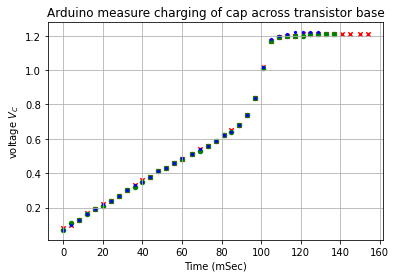

In [16]:
fig, ax = plt.subplots()
markers = ['x', 'o', '.']
mcolours = ['red', 'green', 'blue']
ax.set_title('Arduino measure charging of cap across transistor base')
for idx in range(0,3):
    pdmeasure = pd.DataFrame(measurements[idx])
    pdmeasure.columns = ['time', 'ADC', 'volts']
    ax1 = pdmeasure.plot('time', 'volts', kind='scatter', ax=ax, 
                         marker=markers[idx], color=mcolours[idx])
ax1.set_xlabel('Time (mSec)')
ax1.set_ylabel('voltage $V_C$')
ax1.grid()